In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


In [164]:
#!pip install seaborn==0.9.0
#!pip list

## Откроем файл котировок



In [4]:
#f = open("Data/TQBR.SBER_D1.txt", "r")

In [3]:
df = pd.read_csv('Data/TQBR.GAZP_1H.txt', sep='\t')
#df.datetime = df.datetime.astype('datetime64')

In [4]:
df.datetime

0       04.06.2021 17:00
1       04.06.2021 18:00
2       04.06.2021 19:00
3       04.06.2021 20:00
4       04.06.2021 21:00
              ...       
2995    01.04.2022 14:00
2996    01.04.2022 15:00
2997    01.04.2022 16:00
2998    01.04.2022 17:00
2999    01.04.2022 18:00
Name: datetime, Length: 3000, dtype: object

In [5]:
def func_1(x):
    
    return datetime.strptime(x[:10], '%d.%m.%Y')

df.datetime = df.datetime.apply(lambda x: func_1(x))
df.datetime = df.datetime.astype('datetime64')

In [6]:
df.dtypes

datetime    datetime64[ns]
open               float64
high               float64
low                float64
close              float64
volume               int64
dtype: object

C:\Users\yaroslav\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


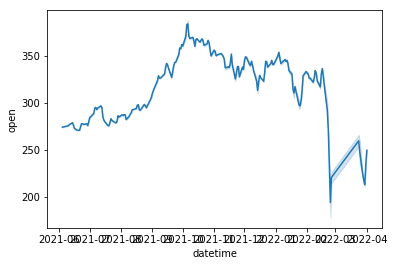

In [7]:
sns.lineplot(data=df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')], x="datetime", y="open")

## MACD

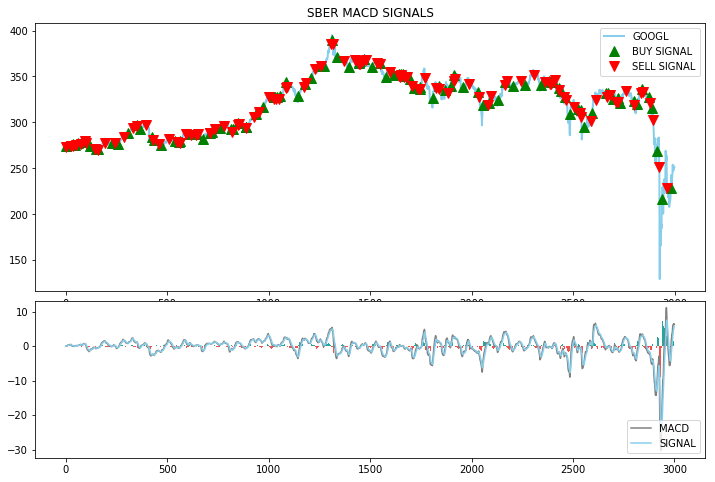

In [17]:
#prod_name = 'TQBR.SBER_D1.txt'

#df = pd.read_csv('Data/' + prod_name, sep='\t')
df = pd.read_csv('Data/TQBR.GAZP_1H.txt', sep='\t')
    
df.datetime = df.datetime.apply(lambda x: func_1(x))
df.datetime = df.datetime.astype('datetime64')
df = df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')].set_index('datetime')

strategy = get_signals('TQBR.GAZP_H1.txt', df.reset_index())

In [9]:
def get_signals(prod_name ,df):
    
    df = pd.concat([df, get_macd(df['close'], 26, 12, 9)], axis=1)
    #plot_macd(df['close'], df['macd'], df['signal'], df['hist'])
    buy_price, sell_price, macd_signal = implement_macd_strategy(df['close'], df)
    signals_plot(df, buy_price, sell_price, macd_signal)
    strategy = get_position(df, buy_price, sell_price, macd_signal)
    
    return strategy

In [48]:
strategy = get_position(df, buy_price, sell_price, macd_signal)

In [53]:
strategy

,datetime,close,macd,signal,macd_signal,macd_position
0,2021-01-04,212.71,0.000000,0.000000,0,1
1,2021-01-05,215.32,0.208205,0.041641,1,1
2,2021-01-06,214.38,0.293970,0.092107,0,1
3,2021-01-08,225.49,1.244083,0.322502,0,1
4,2021-01-11,227.60,2.142615,0.686525,0,1
...,...,...,...,...,...,...
265,2022-01-18,301.11,-3.345837,0.047835,0,0
266,2022-01-19,318.36,-4.304683,-0.822668,0,0
267,2022-01-20,310.42,-5.640248,-1.786184,0,0
268,2022-01-21,311.60,-6.528225,-2.734592,0,0


In [11]:
def get_macd(price, slow, fast, smooth):
    
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    
    return df

#googl_macd = get_macd(df['close'], 26, 12, 9)
#googl_macd.tail()

In [12]:
def plot_macd(prices, macd, signal, hist):
    
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

#plot_macd(df['close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])

In [13]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            

In [16]:
def signals_plot(df, buy_price, sell_price, macd_signal):

    plt.figure(figsize=(12,8))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)
    
    ax1.plot(df['close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
    ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
    ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
    ax1.legend()
    ax1.set_title('SBER MACD SIGNALS')
    ax2.plot(df['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(df['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    
    for i in range(len(df)):
        if str(df['hist'][i])[0] == '-':
            ax2.bar(df.index[i], df['hist'][i], color = '#ef5350')
        else:
            ax2.bar(df.index[i], df['hist'][i], color = '#26a69a')
            
    plt.legend(loc = 'lower right')
    plt.show()

In [14]:
def get_position(df, buy_price, sell_price, macd_signal):
    
    position = []
    for i in range(len(macd_signal)):
        if macd_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)
            
    for i in range(len(df['close'])):
        if macd_signal[i] == 1:
            position[i] = 1
        elif macd_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
            
    macd = df['macd']
    signal = df['signal']
    datetime = df['datetime']
    close_price = df['close']
    macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(df.index)
    position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(df.index)
    
    frames = [datetime, close_price, macd, signal, macd_signal, position]
    strategy = pd.concat(frames, join = 'inner', axis = 1)
    
    return strategy

In [139]:
strategy.macd_signal.value_counts()

 0    482
-1     15
 1     15
Name: macd_signal, dtype: int64

## Тестирование

In [118]:
# c 2021  
googl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(googl_ret)):
    try:
        returns = googl_ret['returns'][i]*strategy.reset_index(drop=True)['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 10000
number_of_stocks = investment_value/df['close'][0]
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret/investment_value)*100
print('Profit gained from the MACD strategy by investing 10k in GOOGL : {}'.format(total_investment_ret))
print('Profit percentage of the MACD strategy : {}%'.format(profit_percentage))

Profit gained from the MACD strategy by investing 10k in GOOGL : 2625.37
Profit percentage of the MACD strategy : 26.253699999999995%


In [140]:
# c 2020
googl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(googl_ret)):
    try:
        returns = googl_ret['returns'][i]*strategy.reset_index(drop=True)['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 10000
number_of_stocks = investment_value/df['close'][0]
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret/investment_value)*100
print('Profit gained from the MACD strategy by investing 10k in GOOGL : {}'.format(total_investment_ret))
print('Profit percentage of the MACD strategy : {}%'.format(profit_percentage))

Profit gained from the MACD strategy by investing 10k in GOOGL : 5509.41
Profit percentage of the MACD strategy : 55.094100000000005%


In [76]:
strategy.loc[lambda x: x.datetime >= pd.to_datetime('2021-06-01')].macd_signal.value_counts()

 0    153
 1      3
-1      3
Name: macd_signal, dtype: int64

## Газпром

In [15]:
googl_ret = pd.DataFrame(np.diff(df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')]['close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(googl_ret)):
    try:
        returns = googl_ret['returns'][i]*strategy.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')].reset_index(drop=True)['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 10000
number_of_stocks = investment_value/df['close'][0]
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret/investment_value)*100
print('Profit gained from the MACD strategy by investing 10k in GOOGL : {}'.format(total_investment_ret))
print('Profit percentage of the MACD strategy : {}%'.format(profit_percentage))


Profit gained from the MACD strategy by investing 10k in GOOGL : 2752.03
Profit percentage of the MACD strategy : 27.520300000000002%


In [16]:
strategy.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')].macd_signal.value_counts()

 0    237
 1     13
-1     12
Name: macd_signal, dtype: int64

## YNDX

In [220]:
# BACKTESTING газпром

aapl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
wr_macd_strategy_ret = []

for i in range(len(aapl_ret)):
    try:
        returns = aapl_ret['returns'][i] * strategy['macd_position'][i]
        wr_macd_strategy_ret.append(returns)
    except:
        pass
    
wr_macd_strategy_ret_df = pd.DataFrame(wr_macd_strategy_ret).rename(columns = {0:'wr_macd_returns'})

investment_value = 10000
number_of_stocks = investment_value / df['close'][0]
wr_macd_investment_ret = []

for i in range(len(wr_macd_strategy_ret_df['wr_macd_returns'])):
    returns = number_of_stocks * wr_macd_strategy_ret_df['wr_macd_returns'][i]
    wr_macd_investment_ret.append(returns)

wr_macd_investment_ret_df = pd.DataFrame(wr_macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(wr_macd_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret / investment_value) * 100
print('Profit gained from the W%R MACD strategy by investing $100k in AAPL : {}'.format(total_investment_ret))
print('Profit percentage of the W%R MACD strategy : {}%'.format(profit_percentage))

Profit gained from the W%R MACD strategy by investing $100k in AAPL : 403.46
Profit percentage of the W%R MACD strategy : 4.0346%


In [58]:
googl_ret

,returns
0,3.20
1,-2.27
2,10.71
3,5.85
4,0.50
...,...
256,11.98
257,-1.23
258,-17.23
259,6.91


## William R

In [191]:
# WILLIAMS %R CALCULATION

def get_wr(high, low, close, lookback):
    highh = high.rolling(lookback).max() 
    lowl = low.rolling(lookback).min()
    wr = -100 * ((highh - close) / (highh - lowl))
    return wr

df['wr_14'] = get_wr(df['high'], df['low'], df['close'], 14)
df.tail()

,datetime,open,high,low,close,volume,wr_14
257,2022-01-03,345.01,353.88,344.30,353.73,4005798,-0.315590
258,2022-01-04,353.99,358.10,348.35,352.55,5269351,-13.217433
259,2022-01-05,351.90,353.50,331.55,335.00,8096944,-55.013098
260,2022-01-06,335.80,347.67,330.11,346.13,7457247,-28.506787
261,2022-01-10,348.56,351.00,340.51,343.70,3758765,-34.293879


In [192]:
# MACD CALCULATION

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    return macd, signal, hist

df['macd'] = get_macd(df['close'], 26, 12, 9)[0]
df['macd_signal'] = get_macd(df['close'], 26, 12, 9)[1]
df['macd_hist'] = get_macd(df['close'], 26, 12, 9)[2]
df = df.dropna()
df.tail()

,datetime,open,high,low,close,volume,wr_14,macd,macd_signal,macd_hist
257,2022-01-03,345.01,353.88,344.30,353.73,4005798,-0.315590,1.620612,-0.825064,2.445676
258,2022-01-04,353.99,358.10,348.35,352.55,5269351,-13.217433,2.431379,-0.173775,2.605155
259,2022-01-05,351.90,353.50,331.55,335.00,8096944,-55.013098,1.638888,0.188757,1.450130
260,2022-01-06,335.80,347.67,330.11,346.13,7457247,-28.506787,1.887176,0.528441,1.358735
261,2022-01-10,348.56,351.00,340.51,343.70,3758765,-34.293879,1.866351,0.796023,1.070328


In [195]:
df = df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')].set_index('datetime')

In [49]:
#df.index = df.index.map(lambda x: x-1)

In [196]:
df

,open,high,low,close,volume,wr_14,macd,macd_signal,macd_hist
datetime,,,,,,,,,
2021-01-22,216.45,216.50,210.50,215.49,9472132,-75.164939,2.056998,2.802170,-0.745173
2021-01-25,216.90,219.66,214.53,218.68,7445654,-60.131951,1.701570,2.582050,-0.880481
2021-01-26,216.80,220.29,215.71,218.80,4511465,-60.362942,1.413282,2.348297,-0.935014
2021-01-27,219.49,222.00,216.44,217.40,5927176,-67.048711,1.059629,2.090563,-1.030934
2021-01-28,215.91,219.49,214.26,217.70,5234100,-65.616046,0.794407,1.831332,-1.036925
...,...,...,...,...,...,...,...,...,...
2022-01-03,345.01,353.88,344.30,353.73,4005798,-0.315590,1.620612,-0.825064,2.445676
2022-01-04,353.99,358.10,348.35,352.55,5269351,-13.217433,2.431379,-0.173775,2.605155
2022-01-05,351.90,353.50,331.55,335.00,8096944,-55.013098,1.638888,0.188757,1.450130


In [202]:
# TRADING STRATEGY

def implement_wr_macd_strategy(prices, wr, macd, macd_signal):    
    buy_price = []
    sell_price = []
    wr_macd_signal = []
    signal = 0

    for i in range(len(wr)):
        if ((wr[i-1] > -50) & (wr[i] < -50)) & (macd[i] > macd_signal[i]):
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                wr_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                wr_macd_signal.append(0)
                
        elif ((wr[i-1] < -50) & (wr[i] > -50)) & (macd[i] < macd_signal[i]):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                wr_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                wr_macd_signal.append(0)
        
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            wr_macd_signal.append(0)
            
    return buy_price, sell_price, wr_macd_signal
            
buy_price, sell_price, wr_macd_signal = implement_wr_macd_strategy(df['close'], df['wr_14'], df['macd'], df['macd_signal'])

In [203]:
# POSITION

position = []
for i in range(len(wr_macd_signal)):
    if wr_macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if wr_macd_signal[i] == 1:
        position[i] = 1
    elif wr_macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = df['close']
wr = df['wr_14']
macd_line = df['macd']
signal_line = df['macd_signal']
wr_macd_signal = pd.DataFrame(wr_macd_signal).rename(columns = {0:'wr_macd_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'wr_macd_position'}).set_index(df.index)

frames = [close_price, wr, macd_line, signal_line, wr_macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,close,wr_14,macd,macd_signal,wr_macd_signal,wr_macd_position
datetime,,,,,,
2021-01-22,215.49,-75.164939,2.056998,2.802170,0,1
2021-01-25,218.68,-60.131951,1.701570,2.582050,0,1
2021-01-26,218.80,-60.362942,1.413282,2.348297,0,1
2021-01-27,217.40,-67.048711,1.059629,2.090563,0,1
2021-01-28,217.70,-65.616046,0.794407,1.831332,0,1


In [176]:
# газпром
strategy.wr_macd_signal.value_counts()

 0    222
 1     20
-1     20
Name: wr_macd_signal, dtype: int64

In [160]:
# сбер
strategy.wr_macd_signal.value_counts()

 0    209
 1     20
-1     20
Name: wr_macd_signal, dtype: int64

In [66]:
# BACKTESTING газпром

aapl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
wr_macd_strategy_ret = []

for i in range(len(aapl_ret)):
    try:
        returns = aapl_ret['returns'][i] * strategy['wr_macd_position'][i]
        wr_macd_strategy_ret.append(returns)
    except:
        pass
    
wr_macd_strategy_ret_df = pd.DataFrame(wr_macd_strategy_ret).rename(columns = {0:'wr_macd_returns'})

investment_value = 10000
number_of_stocks = investment_value / df['close'][0]
wr_macd_investment_ret = []

for i in range(len(wr_macd_strategy_ret_df['wr_macd_returns'])):
    returns = number_of_stocks * wr_macd_strategy_ret_df['wr_macd_returns'][i]
    wr_macd_investment_ret.append(returns)

wr_macd_investment_ret_df = pd.DataFrame(wr_macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(wr_macd_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret / investment_value) * 100
print('Profit gained from the W%R MACD strategy by investing $100k in AAPL : {}'.format(total_investment_ret))
print('Profit percentage of the W%R MACD strategy : {}%'.format(profit_percentage))

Profit gained from the W%R MACD strategy by investing $100k in AAPL : 912.98
Profit percentage of the W%R MACD strategy : 9.129800000000001%


In [85]:
# BACKTESTING сбер

aapl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
wr_macd_strategy_ret = []

for i in range(len(aapl_ret)):
    try:
        returns = aapl_ret['returns'][i] * strategy['wr_macd_position'][i]
        wr_macd_strategy_ret.append(returns)
    except:
        pass
    
wr_macd_strategy_ret_df = pd.DataFrame(wr_macd_strategy_ret).rename(columns = {0:'wr_macd_returns'})

investment_value = 10000
number_of_stocks = investment_value / df['close'][0]
wr_macd_investment_ret = []

for i in range(len(wr_macd_strategy_ret_df['wr_macd_returns'])):
    returns = number_of_stocks * wr_macd_strategy_ret_df['wr_macd_returns'][i]
    wr_macd_investment_ret.append(returns)

wr_macd_investment_ret_df = pd.DataFrame(wr_macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(wr_macd_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret / investment_value) * 100
print('Profit gained from the W%R MACD strategy by investing $10k in AAPL : {}'.format(total_investment_ret))
print('Profit percentage of the W%R MACD strategy : {}%'.format(profit_percentage))

Profit gained from the W%R MACD strategy by investing $10k in AAPL : 1146.32
Profit percentage of the W%R MACD strategy : 11.4632%


In [177]:
# BACKTESTING gazp macd | william

aapl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
wr_macd_strategy_ret = []

for i in range(len(aapl_ret)):
    try:
        returns = aapl_ret['returns'][i] * strategy['wr_macd_position'][i]
        wr_macd_strategy_ret.append(returns)
    except:
        pass
    
wr_macd_strategy_ret_df = pd.DataFrame(wr_macd_strategy_ret).rename(columns = {0:'wr_macd_returns'})

investment_value = 10000
number_of_stocks = investment_value / df['close'][0]
wr_macd_investment_ret = []

for i in range(len(wr_macd_strategy_ret_df['wr_macd_returns'])):
    returns = number_of_stocks * wr_macd_strategy_ret_df['wr_macd_returns'][i]
    wr_macd_investment_ret.append(returns)

wr_macd_investment_ret_df = pd.DataFrame(wr_macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(wr_macd_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret / investment_value) * 100
print('Profit gained from the W%R MACD strategy by investing $10k in AAPL : {}'.format(total_investment_ret))
print('Profit percentage of the W%R MACD strategy : {}%'.format(profit_percentage))

Profit gained from the W%R MACD strategy by investing $10k in AAPL : 3163.46
Profit percentage of the W%R MACD strategy : 31.634600000000002%


In [204]:
# BACKTESTING сбер macd | william

aapl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
wr_macd_strategy_ret = []

for i in range(len(aapl_ret)):
    try:
        returns = aapl_ret['returns'][i] * strategy['wr_macd_position'][i]
        wr_macd_strategy_ret.append(returns)
    except:
        pass
    
wr_macd_strategy_ret_df = pd.DataFrame(wr_macd_strategy_ret).rename(columns = {0:'wr_macd_returns'})

investment_value = 10000
number_of_stocks = investment_value / df['close'][0]
wr_macd_investment_ret = []

for i in range(len(wr_macd_strategy_ret_df['wr_macd_returns'])):
    returns = number_of_stocks * wr_macd_strategy_ret_df['wr_macd_returns'][i]
    wr_macd_investment_ret.append(returns)

wr_macd_investment_ret_df = pd.DataFrame(wr_macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(wr_macd_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret / investment_value) * 100
print('Profit gained from the W%R MACD strategy by investing $10k in AAPL : {}'.format(total_investment_ret))
print('Profit percentage of the W%R MACD strategy : {}%'.format(profit_percentage))

Profit gained from the W%R MACD strategy by investing $10k in AAPL : 941.11
Profit percentage of the W%R MACD strategy : 9.4111%


In [205]:
strategy.loc[lambda x: abs(x.wr_macd_signal)==1]

,close,wr_14,macd,macd_signal,wr_macd_signal,wr_macd_position
datetime,,,,,,
2021-02-04,219.79,-49.373297,-0.133354,0.467186,-1,0
2021-03-18,224.35,-66.000951,2.270829,2.248672,1,1
2021-04-13,227.99,-30.488815,-0.328783,-0.124758,-1,0
2021-10-08,366.17,-54.062876,14.791827,14.294161,1,1
2021-10-11,369.81,-48.282443,14.115035,14.258335,-1,0
2022-01-05,335.00,-55.013098,1.638888,0.188757,1,1


In [199]:
# сбер
strategy.wr_macd_signal.value_counts()

 0    218
 1     16
-1     15
Name: wr_macd_signal, dtype: int64